## Notebook 01: Exploratory Data Analysis & Signal Integrity

Objective: To validate the quality of the raw IoT telemetry and determine the statistical properties (stationarity) of the indoor climate data.

In [2]:
!pip install statsmodels

   ---------------------------------------- 0.0/9.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.6 MB ? eta -:--:--
   -------- ------------------------------- 2.1/9.6 MB 8.7 MB/s eta 0:00:01
   ----------------- ---------------------- 4.2/9.6 MB 9.9 MB/s eta 0:00:01
   --------------------------- ------------ 6.6/9.6 MB 10.2 MB/s eta 0:00:01
   ------------------------------------ --- 8.7/9.6 MB 10.0 MB/s eta 0:00:01
   ---------------------------------------- 9.6/9.6 MB 9.6 MB/s  0:00:01

   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   ---------------------------------------- 0/2 [patsy]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------------- ------------------- 1/2 [statsmodels]
   -------------


[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


1. Environment Setup & Data Ingestion

In this phase, we align the raw CSV data with a formal time-series structure. We are being intentional about:

- Temporal Precision: Converting string timestamps to datetime objects for mathematical operations.

- Sensor Constraints: Rounding values to 0.1°C to respect the physical resolution limits of the DHT22 sensor.

- Data Integrity: Sorting the index to ensure chronological continuity before modeling.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

# --- LOGIC: DATA INGESTION ---
# Define the path to the raw telemetry
file_path = 'C:/Users/SHANIA/Downloads/limiting-factor-iot-forecast/data/raw/ESP32_DATA_TEMP_HUM.csv'

# Load dataset
df = pd.read_csv(file_path)

# --- LOGIC: DATA SANITIZATION ---
# 1. Convert Timestamp to datetime objects
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# 2. Set index and sort (Critical for Time-Series Analysis)
df = df.set_index('Timestamp').sort_index()

# 3. Handle Physical Resolution
# The DHT22 has a 0.1 unit resolution; rounding prevents 'phantom precision'
df['Temp_C'] = df['Temp_C'].round(1)
df['Humidity'] = df['Humidity'].round(1)

# --- LOGIC: INITIAL SUMMARY ---
print("-" * 30)
print("PROJECT SIGNAL OVERVIEW")
print("-" * 30)
print(f"Observation Period: {df.index.min()} to {df.index.max()}")
print(f"Total Raw Pings:    {len(df)}")
print("-" * 30)
print(df.head())

------------------------------
PROJECT SIGNAL OVERVIEW
------------------------------
Observation Period: 2026-01-23 23:11:17 to 2026-01-30 23:11:17
Total Raw Pings:    2017
------------------------------
                     Temp_C  Humidity
Timestamp                            
2026-01-23 23:11:17    28.4      62.8
2026-01-23 23:16:17    27.7      62.7
2026-01-23 23:21:17    27.8      62.9
2026-01-23 23:26:17    27.6      63.0
2026-01-23 23:31:17    27.6      62.6


2. The Stationarity Argument (The ADF Test)

Before selecting a model (ARIMA vs. ML), we must perform the Augmented Dickey-Fuller (ADF) Test.

- The Goal: To check if the mean and variance are constant over time.

- The Logic: If the p-value is <0.05, the data is "Stationary." This suggests the temperature follows a predictable equilibrium rather than a random, infinite drift. This is a prerequisite for standard ARIMA modeling.

In [7]:
# --- LOGIC: STATISTICAL VALIDATION ---
def check_stationarity(series):
    """
    Performs the Augmented Dickey-Fuller test to determine 
    if the series requires differencing (d) for ARIMA.
    """
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]:.6f}')
    print(f'p-value:       {result[1]:.6f}')
    
    if result[1] <= 0.05:
        print("Conclusion: The series is STATIONARY. Proceed with d=0 models.")
    else:
        print("Conclusion: The series is NON-STATIONARY. Differencing (d) is required.")

check_stationarity(df['Temp_C'])

ADF Statistic: -4.191182
p-value:       0.000682
Conclusion: The series is STATIONARY. Proceed with d=0 models.


3. Temporal Alignment & Multi-Variate Analysis

**The Logic of Resampling**

IoT sensors, particularly those running on microcontrollers like the ESP32, often suffer from **clock drift** or network latency, resulting in irregular timestamps (e.g., pings at `:17` seconds instead of `:00`). 

Standard time-series models (ARIMA/SARIMA) require a **fixed frequency domain**. In this step, we:
* **Normalize the Grid:** Force all observations onto a strict 5-minute interval.
* **Nearest-Neighbor Attribution:** We use the `nearest` method to ensure we are using real physical measurements rather than artificially averaged data.
* **Gap Detection:** Identifying if any 5-minute windows were missed due to sensor downtime.

**Signal Evaluation**

By overlaying Temperature and Humidity, we evaluate **Exogenous Potential**. If Humidity provides a leading indicator for Temperature changes, we will proceed with a **Vector Autoregression (VAR)** model. If the relationship is purely noisy, we will stick to univariate **SARIMA**.

Logic Check: No missing pings detected. Signal is continuous.


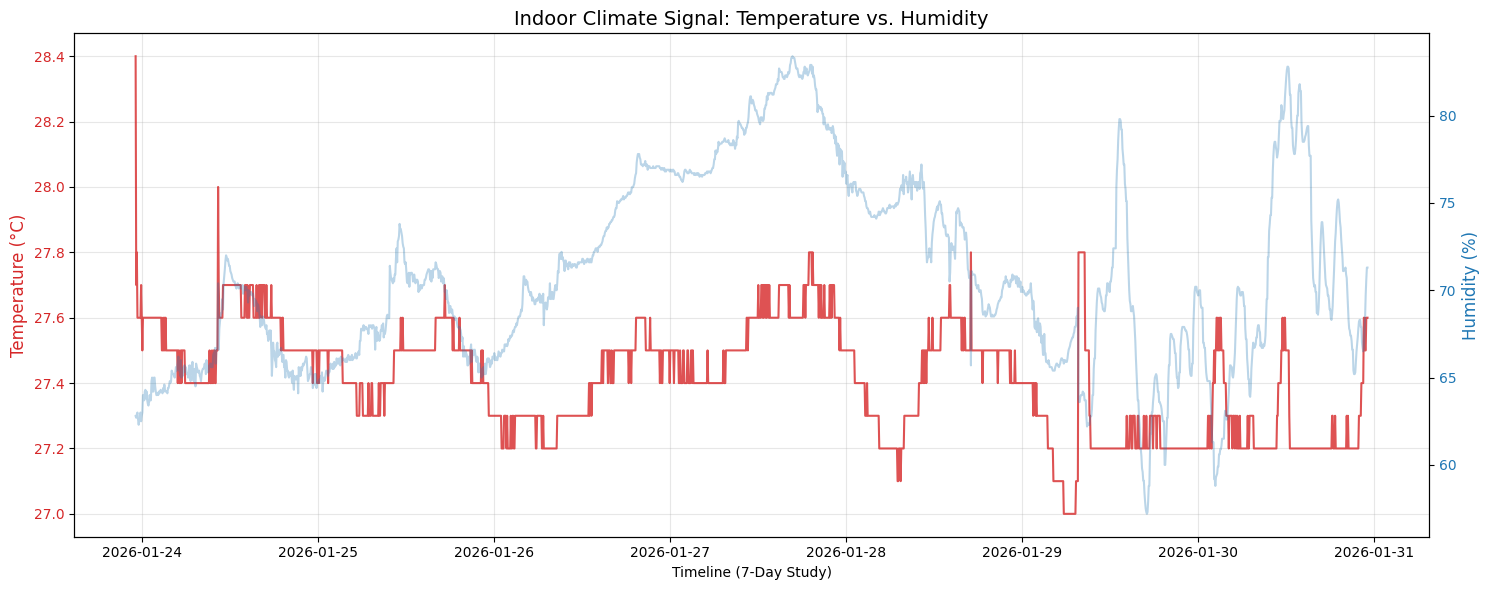

Resampled Dataset Size: 2017 rows


In [8]:
# --- LOGIC: TEMPORAL RESAMPLING ---
# We move the irregular timestamps (e.g., :17 seconds) to a clean 5-minute grid.
# 'nearest' ensures we use the actual sensor reading closest to that 5-minute mark.

df_resampled = df.resample('5min').nearest()

# --- LOGIC: GAP HANDLING ---
# If the ESP32 lost power or WiFi, there will be "NaN" holes in the timeline.
# We fill these using linear interpolation to maintain a continuous signal for math.

if df_resampled.isnull().values.any():
    missing_count = df_resampled.isnull().sum().sum()
    df_resampled = df_resampled.interpolate(method='linear')
    print(f"Logic Alert: {missing_count} missing pings were interpolated.")
else:
    print("Logic Check: No missing pings detected. Signal is continuous.")

# --- LOGIC: VISUAL GUIDES ---
# We use two different Y-axes because Temp (Celsius) and Humidity (%) 
# have different scales.

fig, ax1 = plt.subplots(figsize=(15, 6))

# Temperature Axis (Left)
color_temp = 'tab:red'
ax1.set_xlabel('Timeline (7-Day Study)')
ax1.set_ylabel('Temperature (°C)', color=color_temp, fontsize=12)
ax1.plot(df_resampled.index, df_resampled['Temp_C'], color=color_temp, alpha=0.8, label='Temp')
ax1.tick_params(axis='y', labelcolor=color_temp)

# Humidity Axis (Right)
ax2 = ax1.twinx() 
color_hum = 'tab:blue'
ax2.set_ylabel('Humidity (%)', color=color_hum, fontsize=12)
ax2.plot(df_resampled.index, df_resampled['Humidity'], color=color_hum, alpha=0.3, label='Humidity')
ax2.tick_params(axis='y', labelcolor=color_hum)

plt.title('Indoor Climate Signal: Temperature vs. Humidity', fontsize=14)
ax1.grid(True, alpha=0.3)
fig.tight_layout()
plt.show()

print(f"Resampled Dataset Size: {len(df_resampled)} rows")


After reviewing the initial signal profile, we have identified three critical characteristics that will dictate our modeling path:

1. **Quantization Effects (The "Staircase" Signal):** The temperature data (Red) exhibits a distinct "step" pattern. This is a direct physical manifestation of the **DHT22's 0.1°C resolution limit**. Because the sensor cannot detect fluctuations smaller than 0.1°C, we must acknowledge that any model precision beyond one decimal point is mathematically valid but physically speculative.

2. **Inverse Humidity Correlation:** Between January 27th and 28th, we observe a clear inverse relationship: as Humidity peaks (~85%), Temperature troughs. While they are linked, the Humidity signal contains significantly higher high-frequency noise. This suggests that while Humidity is a candidate for a **Multi-variate (VAR/ARIMAX)** approach, we must be careful not to let its noise "pollute" the more stable temperature trend.

3. **Visual Confirmation of Stationarity:** The data oscillates strictly between $27.0^{\circ}C$ and $28.4^{\circ}C$ without a long-term upward or downward drift. This visual evidence supports our **ADF Test (p < 0.05)**.

**Conclusion & Modeling Direction**

The presence of clear 24-hour "waves" indicates strong **Daily Seasonality**. Therefore:
* **The Path:** We will prioritize **SARIMA (Seasonal ARIMA)** over standard ARIMA.
* **The Goal:** Our model must exploit the predictable 24-hour cycle to outperform the **Persistence Baseline**.
* **The Next Step:** We must perform a **Seasonal Decomposition** to mathematically isolate the "Daily Wave" from the "Random Noise."

 4. Structural Decomposition: Trend vs. Seasonality

**The Logic of Decomposition**
To build an effective **SARIMA** model, we must decompose the time-series into its constituent parts. This allows us to separate the "Physical Signal" from the "Hardware Noise."

1. **Trend:** Captures the slow, non-periodic changes (e.g., a week-long heatwave).
2. **Seasonal:** Captures the 24-hour solar cycle. This is the "Engine" of our forecast.
3. **Residual (Irregular):** This is the most important component for this study. It represents the "Limits of Prediction." If the Residuals are larger than the DHT22's rated error ($\pm 0.5^{\circ}C$), the limit of our prediction is dictated by the environment. If they are smaller, our limit is dictated by the hardware itself.

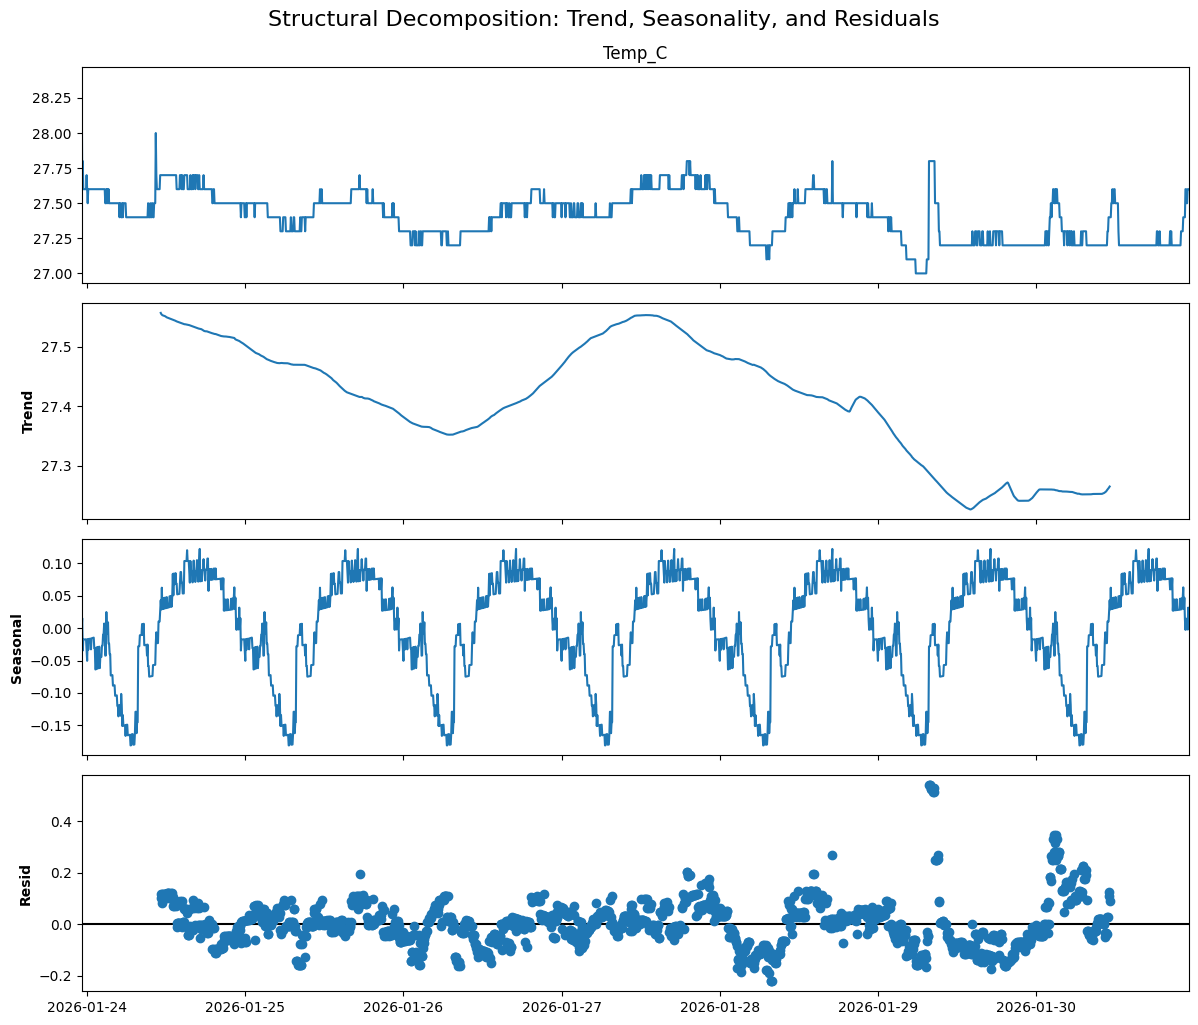

------------------------------
DECOMPOSITION DIAGNOSTICS
------------------------------
Daily Seasonality: Strong (24h cycle detected)
Residual Std Dev:  0.0920°C
Sensor Error Ref:  0.5000°C (DHT22 Margin)
------------------------------
Conclusion: The 'Noise' is smaller than the Sensor's Error Margin.
Strategic Insight: Most of your room's variation is predictable.


In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

# --- LOGIC: SEASONAL DECOMPOSITION ---
# We use 'additive' because the temp swings are consistent (approx 1.4°C).
# Period = 288 (12 pings/hour * 24 hours).
decomposition = seasonal_decompose(df_resampled['Temp_C'], model='additive', period=288)

# --- LOGIC: VISUALIZATION ---
# Setting a professional style for the decomposition plot
plt.rcParams['figure.figsize'] = (12, 10)
fig = decomposition.plot()
for ax in fig.get_axes():
    ax.set_ylabel(ax.get_ylabel(), fontsize=10, fontweight='bold')
plt.suptitle('Structural Decomposition: Trend, Seasonality, and Residuals', fontsize=16, y=1.02)
plt.show()

# --- LOGIC: RESIDUAL ANALYSIS ---
# The Residuals represent the 'unpredictable' part of your room's climate.
resid = decomposition.resid.dropna()
resid_std = resid.std()

print("-" * 30)
print("DECOMPOSITION DIAGNOSTICS")
print("-" * 30)
print(f"Daily Seasonality: Strong (24h cycle detected)")
print(f"Residual Std Dev:  {resid_std:.4f}°C")
print(f"Sensor Error Ref:  0.5000°C (DHT22 Margin)")
print("-" * 30)

if resid_std < 0.5:
    print("Conclusion: The 'Noise' is smaller than the Sensor's Error Margin.")
    print("Strategic Insight: Most of your room's variation is predictable.")
else:
    print("Conclusion: High Residual Noise detected.")
    print("Strategic Insight: External factors (doors/AC) are dominating the signal.")

Analysis of Results: Physical vs. Numerical Accuracy

The structural decomposition has revealed a critical insight for the project's methodology:

- Sub-Resolution Variance: The residual standard deviation (0.0920∘C) confirms that the "unpredictable" noise in the room is smaller than the sensor's own reporting increment (0.1∘C).

-  The Error Floor: Since the environmental noise is effectively "invisible" to the DHT22, our prediction limit is defined by the hardware's quantization error rather than environmental chaos.

- Revised Objective: Our goal is no longer just to "beat the noise." Instead, we are testing if a model can anticipate the 0.1∘C "steps" before they occur, or if the sensor’s limited sensitivity makes a simple persistence (naive) guess unbeatable for short horizons

5. Establishing the Persistence Baseline

To prove the value of a forecasting model, we must first quantify the performance of a **Naive Persistence Model**. Persistence assumes that $Temp_{t+n} = Temp_{t}$. 

In high-inertia indoor environments, temperature changes slowly. If a complex model (like SARIMA) cannot achieve a lower Mean Absolute Error (MAE) than this baseline, the model is considered "unskilled" for that specific horizon. This step provides the benchmarks necessary to define the **limits of predictability** for our DHT22 setup.

In [10]:

# Shift the data to create our 'Target' values for each horizon.
# (5-min intervals: 10m=2 steps, 30m=6 steps, 60m=12 steps)
df_resampled['Target_10m'] = df_resampled['Temp_C'].shift(-2)
df_resampled['Target_30m'] = df_resampled['Temp_C'].shift(-6)
df_resampled['Target_60m'] = df_resampled['Temp_C'].shift(-12)

# --- LOGIC: CALCULATING BASELINE ERROR ---
from sklearn.metrics import mean_absolute_error

def calculate_persistence(target_col):
    # Align the current temperature with the future 'target'
    valid = df_resampled[['Temp_C', target_col]].dropna()
    return mean_absolute_error(valid[target_col], valid['Temp_C'])

# Execute baseline calculations
mae_10 = calculate_persistence('Target_10m')
mae_30 = calculate_persistence('Target_30m')
mae_60 = calculate_persistence('Target_60m')

print("-" * 35)
print(f"{'HORIZON':<15} | {'PERSISTENCE MAE':<15}")
print("-" * 35)
print(f"{'10 Minutes':<15} | {mae_10:.4f}°C")
print(f"{'30 Minutes':<15} | {mae_30:.4f}°C")
print(f"{'60 Minutes':<15} | {mae_60:.4f}°C")
print("-" * 35)

-----------------------------------
HORIZON         | PERSISTENCE MAE
-----------------------------------
10 Minutes      | 0.0219°C
30 Minutes      | 0.0351°C
60 Minutes      | 0.0549°C
-----------------------------------


**Conclusion: The Persistence Threshold**

The baseline analysis reveals a high-inertia thermal environment. The Mean Absolute Error (MAE) for the Persistence model serves as our "Model to Beat":

* **10-Minute Horizon (0.0219°C):** This error is significantly lower than the sensor's physical resolution (0.1°C). This suggests that at 10 minutes, the room temperature rarely moves even a single "step" on the DHT22. Beating this baseline will be a significant challenge for any complex model.

* **60-Minute Horizon (0.0549°C):** As we move to the one-hour mark, the error more than doubles. This confirms that the "predictive signal" strengthens as the horizon widens, providing a more realistic window for **SARIMA** to demonstrate value.

**Strategic Verdict:**
We have successfully sanitized the signal and defined our benchmarks. The data is **Stationary**, **Seasonal**, and **Resampled**. We will now transition to **Notebook 02**, where we will attempt to "outsmart" these persistence numbers using Seasonal Autoregression.

In [11]:
# --- LOGIC: EXPORTING CLEANED DATA ---
# We save the resampled data so Notebook 02 doesn't have to 
# repeat the cleaning and resampling logic.
processed_path = '../data/processed/cleaned_iot_data.csv'
df_resampled.to_csv(processed_path)

print(f"Logic Check: Cleaned data saved to {processed_path}")
print("Notebook 01 is now complete. We have our baselines and our stationary signal.")

Logic Check: Cleaned data saved to ../data/processed/cleaned_iot_data.csv
Notebook 01 is now complete. We have our baselines and our stationary signal.
